# Predict how many hour a person spend each day at Benton

## Assemble data

### Read data

In [1]:
from pandas import read_csv, concat
data = read_csv('../../data/dt.consecutive.csv', iterator=True, chunksize=1000000)
data = concat(chunk[chunk['MAC'] == 'd4:c9:4b:c4:bd:6a'] for chunk in data)

### Convert to date time

In [2]:
data.drop('Unnamed: 0', axis=1, inplace=True)
from datetime import datetime

def format(time):
    return datetime.strptime(time, '%Y-%m-%d %H:%M:%S')

data['time'] = [format(time) for time in data['time']]

In [4]:
#data = data[data['time'].dt.month < 3]

### Visualize

Text(0.5, 0, 'Day')

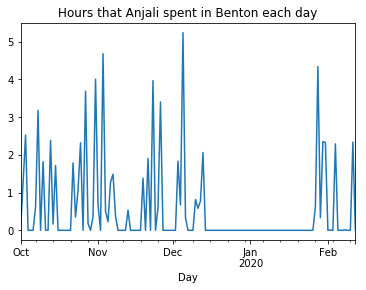

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas import date_range

def cal(day):
    current = 0
    prev = 0
    sum = 0
    for probe in day['time']:
        prev = current
        current = probe
        if prev != 0:
            diff = (current - prev).seconds
            if diff < 600:
                sum += diff
            else:
                sum+= 600
    return sum / 3600

range2 = date_range('10-01-2019', '02-12-2020')

data2 = data.groupby(data['time'].dt.floor('d')).apply(cal)
data2 = data2.reindex(range2, fill_value=0)
graph = data2.plot(title = 'Hours that Anjali spent in Benton each day')
graph.set_xlabel('Day')
# plt.savefig('Anjali2.jpg', dpi=1200, bbox_inches = 'tight')

### Size of history in days

In [4]:
size_h = 14

### Add new column for break period

In [5]:
from pandas import DataFrame

def format2(time):
    return datetime.strptime(time, '%Y-%m-%d')

def br(time):
    if time >= format2('2019-10-11') and time < format2('2019-10-14'): # Fall break
        return True
    if time >= format2('2019-11-27') and time < format2('2019-12-02'): # Thanksgiving
        return True
    if time >= format2('2019-12-14') and time < format2('2020-01-27'): # Winter break
        return True
    return False

data2 = DataFrame(data2).reset_index()
data2['break'] = [br(time) for time in data2['index']]

### Index of target days in break period

In [6]:
br = [index for index in data2.index[data2['break']].tolist() if index >= size_h]

### Index of target days not in break period

In [7]:
not_br = [index for index in data2.index[data2['break'] == False].tolist() if index >= size_h]

### Standardize data

In [38]:
data2['count'] = data2[0]
mean = data2[0].mean()
std = data2[0].std()
data2[0] = (data2[0] - mean) / std

### Seperate features and target

In [39]:
from numpy import array

def resh(data):
    return data.reshape(data.shape[0], size_h, 1)

def seperate(list):
    x = []
    y = []
    for index in list:
        x.append(data2[0][index - size_h : index])
        y.append(data2[0][index])
    return resh(array(x)), array(y)

### Data in break period

In [40]:
x_br, y_br = seperate(br)

### Data not in break period

In [41]:
x_not, y_not = seperate(not_br)

### Design models using tensorflow keras

In [11]:
from tensorflow.keras.layers import Input, LSTM, Dense, PReLU
from tensorflow.keras.models import Sequential

# shape of output
sh = 32
# optimizer
optimizer = 'nadam'
# loss function
f = 'mse'

def build():
    model = Sequential()
    model.add(LSTM(sh, input_shape=(size_h, 1))) # Long short-term memory
    model.add(Dense(sh, activation='linear')) # Dense
    model.add(PReLU()) # activation for previous dense layer
    model.add(Dense(1, activation='linear')) # output layer
    model.compile(optimizer=optimizer, loss=f)
    return model

## Training

### Build models

In [93]:
model_br = build()
model_not = build()

### Hyperparameters

In [94]:
# numbers of epoch
no = 150
# test set size
size = 0.1

### Visualize training losses

In [95]:
def pl(track):
    loss = track.history['loss']
    val_loss = track.history['val_loss']
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.legend()
    plt.show()

Train on 44 samples, validate on 5 samples
Epoch 1/150
44/44 - 1s - loss: 0.2679 - val_loss: 0.2287
Epoch 2/150
44/44 - 0s - loss: 0.2321 - val_loss: 0.1968
Epoch 3/150
44/44 - 0s - loss: 0.2065 - val_loss: 0.1673
Epoch 4/150
44/44 - 0s - loss: 0.1825 - val_loss: 0.1458
Epoch 5/150
44/44 - 0s - loss: 0.1638 - val_loss: 0.1265
Epoch 6/150
44/44 - 0s - loss: 0.1470 - val_loss: 0.1089
Epoch 7/150
44/44 - 0s - loss: 0.1305 - val_loss: 0.0905
Epoch 8/150
44/44 - 0s - loss: 0.1135 - val_loss: 0.0714
Epoch 9/150
44/44 - 0s - loss: 0.0964 - val_loss: 0.0535
Epoch 10/150
44/44 - 0s - loss: 0.0791 - val_loss: 0.0351
Epoch 11/150
44/44 - 0s - loss: 0.0628 - val_loss: 0.0198
Epoch 12/150
44/44 - 0s - loss: 0.0483 - val_loss: 0.0079
Epoch 13/150
44/44 - 0s - loss: 0.0366 - val_loss: 0.0013
Epoch 14/150
44/44 - 0s - loss: 0.0287 - val_loss: 2.8978e-05
Epoch 15/150
44/44 - 0s - loss: 0.0243 - val_loss: 8.1376e-04
Epoch 16/150
44/44 - 0s - loss: 0.0215 - val_loss: 0.0015
Epoch 17/150
44/44 - 0s - loss

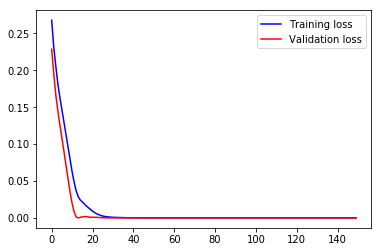

In [96]:
track = model_br.fit(x_br, y_br, epochs=no, verbose=2, validation_split=size, shuffle=True)
pl(track)

Train on 64 samples, validate on 8 samples
Epoch 1/150
64/64 - 2s - loss: 1.6205 - val_loss: 0.5253
Epoch 2/150
64/64 - 0s - loss: 1.6055 - val_loss: 0.5310
Epoch 3/150
64/64 - 0s - loss: 1.5963 - val_loss: 0.5370
Epoch 4/150
64/64 - 0s - loss: 1.5872 - val_loss: 0.5440
Epoch 5/150
64/64 - 0s - loss: 1.5758 - val_loss: 0.5523
Epoch 6/150
64/64 - 0s - loss: 1.5681 - val_loss: 0.5601
Epoch 7/150
64/64 - 0s - loss: 1.5562 - val_loss: 0.5677
Epoch 8/150
64/64 - 0s - loss: 1.5499 - val_loss: 0.5743
Epoch 9/150
64/64 - 0s - loss: 1.5370 - val_loss: 0.5819
Epoch 10/150
64/64 - 0s - loss: 1.5284 - val_loss: 0.5907
Epoch 11/150
64/64 - 0s - loss: 1.5162 - val_loss: 0.6008
Epoch 12/150
64/64 - 0s - loss: 1.5050 - val_loss: 0.6132
Epoch 13/150
64/64 - 0s - loss: 1.4906 - val_loss: 0.6292
Epoch 14/150
64/64 - 0s - loss: 1.4721 - val_loss: 0.6481
Epoch 15/150
64/64 - 0s - loss: 1.4520 - val_loss: 0.6668
Epoch 16/150
64/64 - 0s - loss: 1.4325 - val_loss: 0.6852
Epoch 17/150
64/64 - 0s - loss: 1.4140

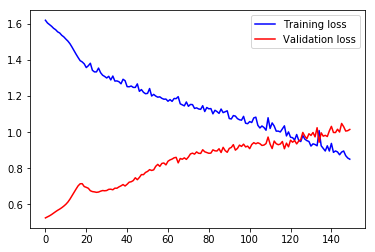

In [97]:
track = model_not.fit(x_not, y_not, epochs=no, verbose=2, validation_split=size, shuffle=True)
pl(track)

## Evaluation

### Cross-validation

In [111]:
from sklearn.model_selection import KFold
from math import sqrt

cv = KFold(n_splits=10, shuffle=True)

# number of epochs
no = 40

def cross_valid(x, y):
    score = 0
    for train, test in cv.split(x, y):    
        model = build()
        model.fit(x[train], y[train], epochs=no, verbose=0, shuffle=True)
        score += sqrt(model.evaluate(x[test], y[test]))
    return score / 10

In [112]:
print(cross_valid(x_br, y_br) * std)

4/4 [==============================] - 0s 108ms/sample - loss: 2.0023e-08
0.021101739402317722


In [113]:
print(cross_valid(x_not, y_not) * std)

7/7 [==============================] - 0s 31ms/sample - loss: 1.9998
1.2478774493863047


In [101]:
data2

,index,0,break,prediction,count
0,2019-10-01,-0.501152,False,NaN,0.000000
1,2019-10-02,0.614702,False,NaN,1.242500
2,2019-10-03,1.764983,False,NaN,2.523333
3,2019-10-04,-0.501152,False,NaN,0.000000
4,2019-10-05,-0.501152,False,NaN,0.000000
5,2019-10-06,-0.501152,False,NaN,0.000000
6,2019-10-07,0.056152,False,NaN,0.620556
7,2019-10-08,2.352472,False,NaN,3.177500
8,2019-10-09,-0.501152,False,NaN,0.000000
9,2019-10-10,1.129597,False,NaN,1.815833


### Prediction

In [98]:
from math import nan

prediction = []
for index in range(len(data2)):
    if index < size_h:
        prediction.append(nan)
    else:
        x = array(data2[0][index - size_h : index]).reshape(1, size_h, 1)
        if data2['break'][index]:
            prediction.append(model_br.predict(x) * std + mean)
        else:
            prediction.append(model_not.predict(x) * std + mean)
data2['prediction'] = [0 if i < 0 else i for i in prediction]

### Visualization

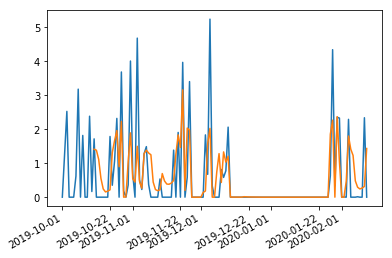

In [99]:
fig, ax = plt.subplots()
ax.plot_date(data2['index'], data2[['count', 'prediction']], '-')
fig.autofmt_xdate()
plt.show()

Closer look

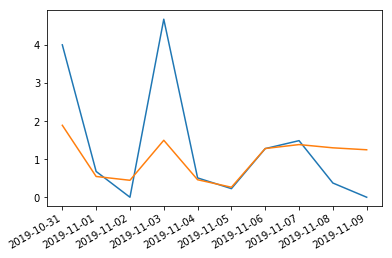

In [103]:
fig, ax = plt.subplots()
ax.plot_date(data2['index'][30:40], data2[['count', 'prediction']][30:40], '-')
fig.autofmt_xdate()
plt.show()

In [70]:
# a = data.groupby(data['time'].dt.floor('d')).apply(cal)

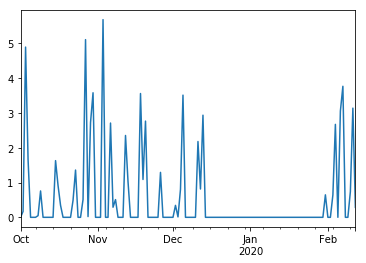

In [81]:
# from pandas import date_range

# idx = date_range('10-01-2019', '02-12-2020')
# a.reindex(idx, fill_value=0).plot()